Runs Scored - Model Evaluation

    - Last time we built a model to predict runs scored given features about the hitting team and the opposing pitchers

    - In this notebook, we will use that model to predict the probability that the total runs scored is over or under the "over/under line" for each game in the test set

    - This first attempt involves an independence assumption which is likely not true in practice, but may be close enough to true to give good predictions

    - We will then evaluate how this model would have fared in practice had we made bets on it, and do some further analysis to see if we really have an edge on the Vegas probabilities for the over/under

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [4]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [5]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],20)

In [6]:
df_train = df_runs[(df_runs.season>2000) & (df_runs.season<=2015) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2016) & (df_runs.season<=2020)]
df_test = df_runs[df_runs.season>=2021]

In [7]:
df_test_game = df[df.season>=2021]

In [8]:
df.head()

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result,Strt_GS_h,Strt_GS_v,Strt_IP_h,Strt_IP_v,Strt_H_h,Strt_H_v,Strt_BFP_h,Strt_BFP_v,Strt_HR_h,Strt_HR_v,Strt_R_h,Strt_R_v,Strt_ER_h,Strt_ER_v,Strt_BB_h,Strt_BB_v,Strt_IB_h,Strt_IB_v,Strt_SO_h,Strt_SO_v,Strt_SH_h,Strt_SH_v,Strt_SF_h,Strt_SF_v,Strt_WP_h,Strt_WP_v,Strt_HBP_h,Strt_HBP_v,Strt_BK_h,Strt_BK_v,Strt_2B_h,Strt_2B_v,Strt_3B_h,Strt_3B_v,Strt_IP_real_h,Strt_IP_real_v,Strt_rollsum_IP_real_6_h,Strt_rollsum_IP_real_6_v,Strt_rollsum_H_6_h,Strt_rollsum_H_6_v,Strt_rollsum_BFP_6_h,Strt_rollsum_BFP_6_v,Strt_rollsum_HR_6_h,Strt_rollsum_HR_6_v,Strt_rollsum_R_6_h,Strt_rollsum_R_6_v,Strt_rollsum_ER_6_h,Strt_rollsum_ER_6_v,Strt_rollsum_BB_6_h,Strt_rollsum_BB_6_v,Strt_rollsum_IB_6_h,Strt_rollsum_IB_6_v,Strt_rollsum_SO_6_h,Strt_rollsum_SO_6_v,Strt_rollsum_SH_6_h,Strt_rollsum_SH_6_v,Strt_rollsum_SF_6_h,Strt_rollsum_SF_6_v,Strt_rollsum_WP_6_h,Strt_rollsum_WP_6_v,Strt_rollsum_HBP_6_h,Strt_rollsum_HBP_6_v,Strt_rollsum_BK_6_h,Strt_rollsum_BK_6_v,Strt_rollsum_2B_6_h,Strt_rollsum_2B_6_v,Strt_rollsum_3B_6_h,Strt_rollsum_3B_6_v,Strt_rollsum_IP_real_15_h,Strt_rollsum_IP_real_15_v,Strt_rollsum_H_15_h,Strt_rollsum_H_15_v,Strt_rollsum_BFP_15_h,Strt_rollsum_BFP_15_v,Strt_rollsum_HR_15_h,Strt_rollsum_HR_15_v,Strt_rollsum_R_15_h,Strt_rollsum_R_15_v,Strt_rollsum_ER_15_h,Strt_rollsum_ER_15_v,Strt_rollsum_BB_15_h,Strt_rollsum_BB_15_v,Strt_rollsum_IB_15_h,Strt_rollsum_IB_15_v,Strt_rollsum_SO_15_h,Strt_rollsum_SO_15_v,Strt_rollsum_SH_15_h,Strt_rollsum_SH_15_v,Strt_rollsum_SF_15_h,Strt_rollsum_SF_15_v,Strt_rollsum_WP_15_h,Strt_rollsum_WP_15_v,Strt_rollsum_HBP_15_h,Strt_rollsum_HBP_15_v,Strt_rollsum_BK_15_h,Strt_rollsum_BK_15_v,Strt_rollsum_2B_15_h,Strt_rollsum_2B_15_v,Strt_rollsum_3B_15_h,Strt_rollsum_3B_15_v,Strt_rollsum_IP_real_30_h,Strt_rollsum_IP_real_30_v,Strt_rollsum_H_30_h,Strt_rollsum_H_30_v,Strt_rollsum_BFP_30_h,Strt_rollsum_BFP_30_v,Strt_rollsum_HR_30_h,Strt_rollsum_HR_30_v,Strt_rollsum_R_30_h,Strt_rollsum_R_30_v,

In [9]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_15',
 'Strt_TB_BB_perc_15',
 'Strt_H_BB_perc_15',
 'Strt_SO_perc_6',
 'Bpen_WHIP_162',
 'Bpen_TB_BB_perc_162',
 'Bpen_H_BB_perc_162',
 'Bpen_SO_perc_162',
 'Bpen_WHIP_30',
 'Bpen_TB_BB_perc_30',
 'Bpen_H_BB_perc_30',
 'Bpen_SO_perc_30',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [28]:
bpv2 = np.linspace(-.5,20.5,22)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5])

In [29]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [30]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4789484280146143


i=10, eval_set_loss = 2.476263112059605
i=20, eval_set_loss = 2.4741938296113704
i=30, eval_set_loss = 2.4727125465065174
i=40, eval_set_loss = 2.4717421797038703
i=50, eval_set_loss = 2.4708757638538015
i=60, eval_set_loss = 2.4703258962768135
i=70, eval_set_loss = 2.469892699238815
i=80, eval_set_loss = 2.4694980913902462
i=90, eval_set_loss = 2.4690326637801108
i=100, eval_set_loss = 2.4687233479285693
i=110, eval_set_loss = 2.468493927238627
i=120, eval_set_loss = 2.4683036242907757
i=130, eval_set_loss = 2.4682056158302235
i=140, eval_set_loss = 2.4681368223672644
i=150, eval_set_loss = 2.4681169176712876
i=160, eval_set_loss = 2.4680736249095134
i=170, eval_set_loss = 2.468080995857652
i=180, eval_set_loss = 2.4680977471406282
i=190, eval_set_loss = 2.4681365059344214
i=200, eval_set_loss = 2.468152022072567
i=210, eval_set_loss = 2.4681929710459647
Stopping early: low pt was 5 steps ago


In [31]:
preds_test = cr1.predict_distributions(X_test)

In [32]:
preds_test.log_loss(y_test)

2.450441740104599

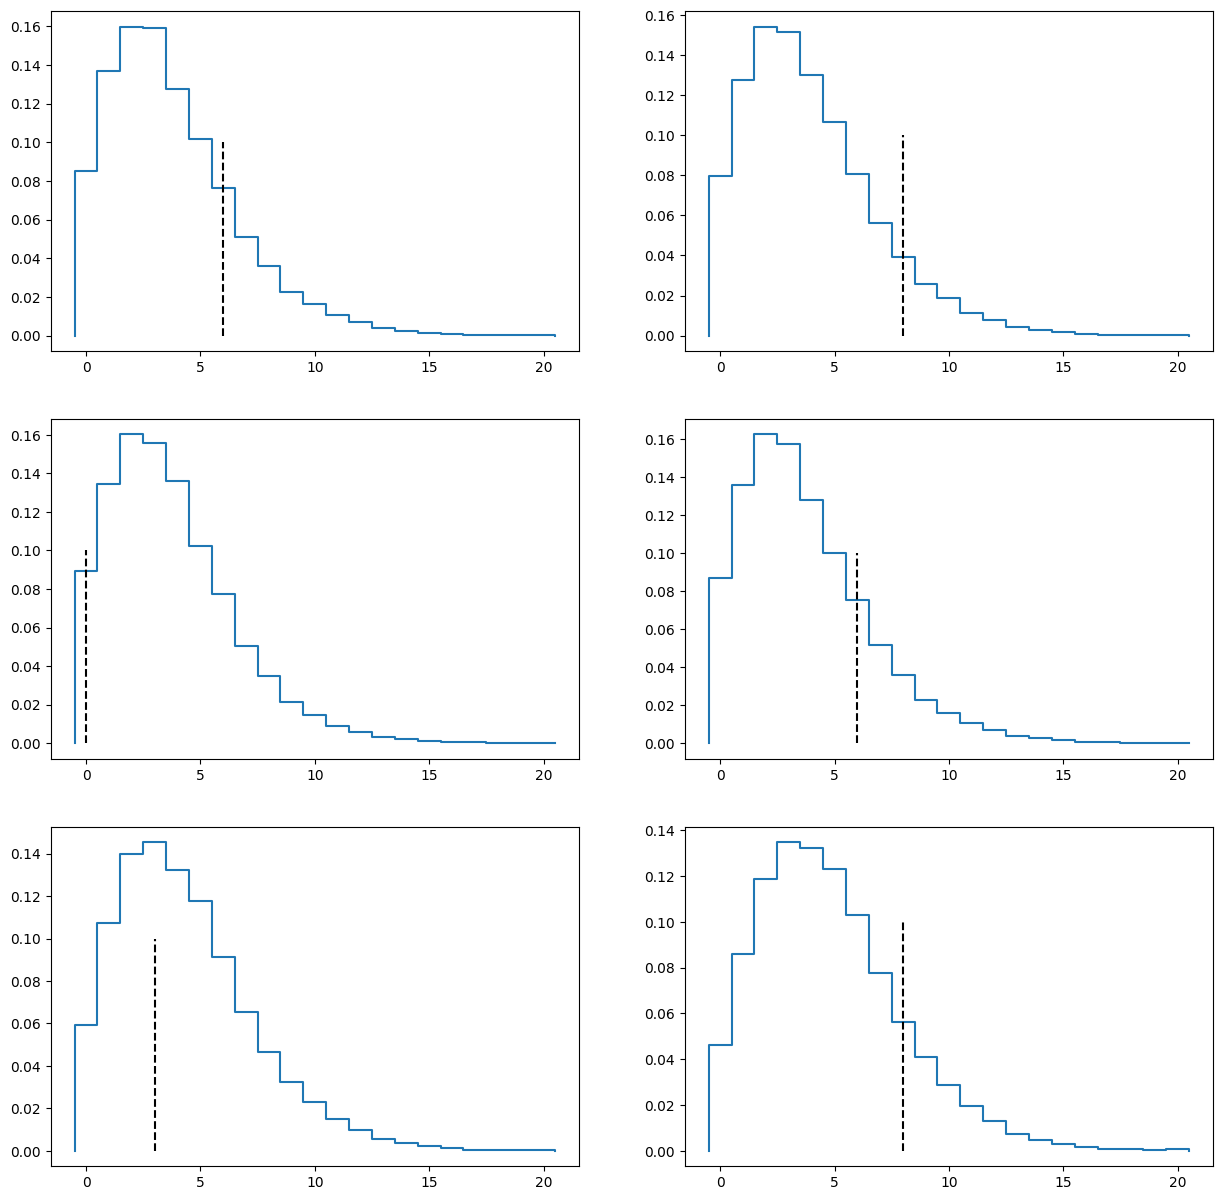

In [33]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.1, color='k', linestyle='--')

Predicting the Over / Under

    - As a first step, we will model the total score as an independent sum of the two scores

    - For baseball, this is not a terrible assumption (would be worse in other sports)

    - Still, would expect some imperfection, since teams make strategic decisions based on the score of the game

        - Play for one run in a close game
        
        - Put a rookie pitcher in with a big lead

In [34]:
def probs_oup_val(probvec_a, probvec_b, val, ties_go_over=True):
    """given two probability distributions and the ou-line, returns prob of under"""
    val_up = int(np.ceil(val))
    val_down = int(np.floor(val))
    cdf_b = np.cumsum(probvec_b)
    prob_under = 0
    prob_push = 0
    if (val_down<val_up): # This means we have a decimal (.5) o/u value - no pushes      
        for i in range(0, val_down+1):
            # calculate prob that we are less than or equal to val_down for each
            # value of probvec_a between 0 and val_down
            prob_under += probvec_a[i] * cdf_b[val_down-i]
        return(1-prob_under-prob_push, prob_under, prob_push)
    else: # This means val_down == val_up == val and we have an integer line so pushes are possible
        for i in range(0, val_down):
            # calculate prob that we are less than or equal to val_down-1 for each
            # value of probvec_a between 0 and val_down
            prob_under += probvec_a[i] * cdf_b[val_down-1-i]
        for j in range(0, val_down+1):
            # calculate prob that we are exactly = val_down
            if (not ties_go_over) or (j != val_down-j): # if line is 10 and predicts score of 5-5, maybe count as over
                prob_push += probvec_a[j] * probvec_b[val_down-j] 
        return(1-prob_under-prob_push, prob_under,  prob_push)

In [35]:
num_games_test=int(df_test.shape[0]/2)

In [36]:
oup_probs = np.array([probs_oup_val(preds_test[i].probvec, preds_test[i+num_games_test].probvec, df_test.over_under_line.iloc[i])
                        for i in range(num_games_test)])

In [37]:
oup_probs[:5,:]

array([[0.65240931, 0.34759069, 0.        ],
       [0.44161764, 0.45735022, 0.10103214],
       [0.22715772, 0.70681858, 0.0660237 ],
       [0.46912662, 0.42862872, 0.10224467],
       [0.4445398 , 0.5554602 , 0.        ]])

In [38]:
oup_probs.mean(axis=0)

array([0.4258439 , 0.53396277, 0.04019333])

In [39]:
df_test.over_under_result.value_counts().sum(), df_test.over_under_result.value_counts()/df_test.over_under_result.value_counts().sum()

(14570,
 U    0.484283
 O    0.471517
 P    0.044200
 Name: over_under_result, dtype: float64)

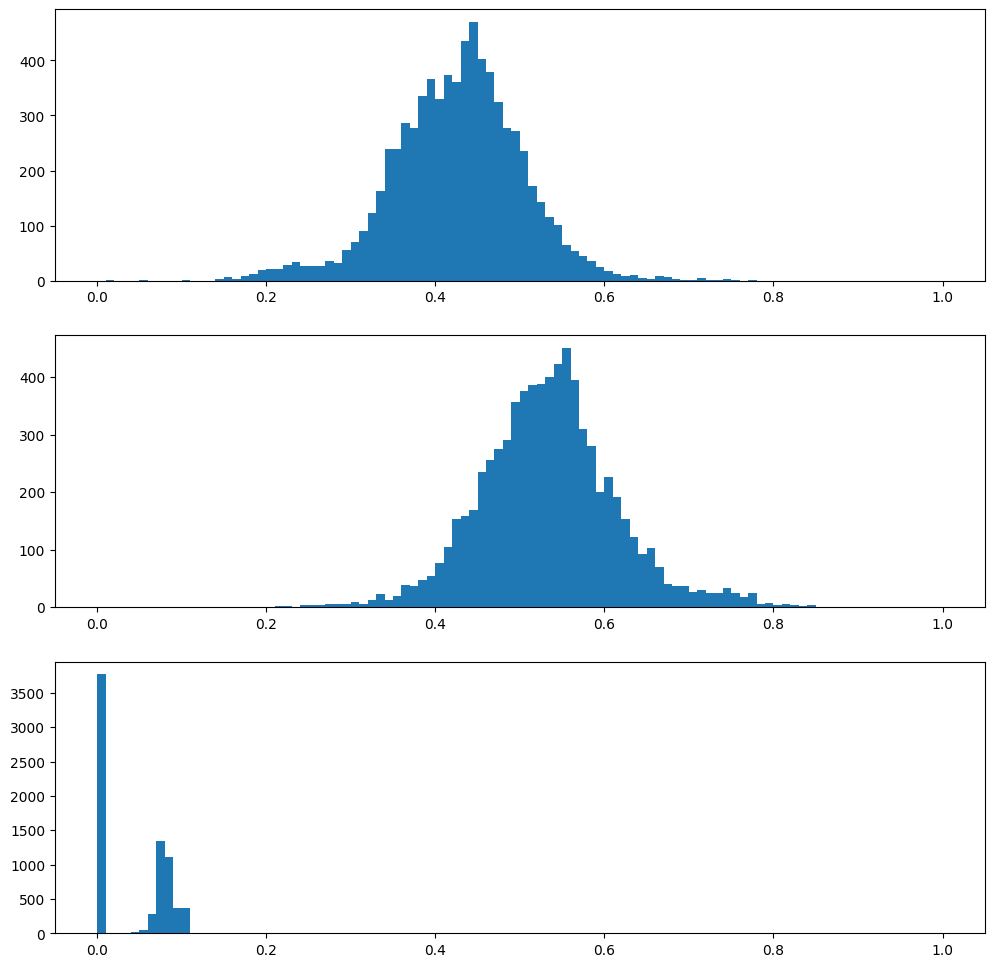

In [40]:
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.hist(oup_probs[:,0], np.linspace(0,1,101));
plt.subplot(3,1,2)
plt.hist(oup_probs[:,1], np.linspace(0,1,101));
plt.subplot(3,1,3)
plt.hist(oup_probs[:,2], np.linspace(0,1,101));

In [41]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')

In [42]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)

threshold = 0.25

There were 177 games that met criteria of edge > 0.25 (169 unders and 8 overs)
Of them 90 (0.508) were correct (winning bets), (87 unders and 3 overs) 
and 4 (0.023) were Pushes (3 unders and 1 overs)
and 83 (0.469) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been -0.0073 per bet
	 for a total profit of -1.3 across all 177 bets


threshold = 0.2

There were 334 games that met criteria of edge > 0.2 (310 unders and 24 overs)
Of them 169 (0.506) were correct (winning bets), (156 unders and 13 overs) 
and 11 (0.033) were Pushes (10 unders and 1 overs)
and 154 (0.461) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been -0.0012 per bet
	 for a total profit of -0.4 across all 334 bets


threshold = 0.15

There were 797 games that met criteria of edge > 0.15 (734 unders and 63 overs)
Of them 388 (0.487) were correct (winning bets), (359 unders and 29 overs) 
and 28 (0.035) were Pushes (2

In [43]:
def evaluate_lkratio(nc, ni, null_prob, alt_prob):
    null_lk = sp.stats.binom.pmf(nc,nc+ni,null_prob)
    alt_lk = sp.stats.binom.pmf(nc,nc+ni,alt_prob)
    return(alt_lk/null_lk)

In [44]:
evaluate_lkratio(90, 83, .5, 90/(90+83))

1.1521815733354952

In [45]:
evaluate_lkratio(169, 154, .5, 169/(169+154))

1.416830753615701

In [46]:
evaluate_lkratio(388, 381, .5, 388/(388+381))

1.0323729607642151

In [47]:
evaluate_lkratio(1012, 983, .5, 1012/(1012+983))

1.2346460947130722

In [48]:
evaluate_lkratio(2155, 2031, .5, 2155/(2155+2031))

6.276841322797772

Conclusions

    - Looks promising that our model could beat Vegas in the long run

    - Would like to see higher likelihood ratios to have more confidence

    - Let's repeat this notebook with more test data (less training data) to see if we can get more convicing evidence